<a href="https://colab.research.google.com/github/bilgeyucel/presentations/blob/main/berlin-buzzwords-2024/early_routing_with_fallback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Early Routing (Tools)

A notebook to use different branches for queries, created with [Haystack](https://github.com/deepset-ai/haystack), the open source LLM framework.

by Bilge Yucel [Twitter](https://twitter.com/bilgeycl), [Linkedin](https://www.linkedin.com/in/bilge-yucel/)


📚 Useful Resources
* [Documentation](https://docs.haystack.deepset.ai/docs?utm_campaign=developer-relations&utm_source=bbuzz&utm_medium=colab)
* [Website](https://haystack.deepset.ai?utm_campaign=developer-relations&utm_source=bbuzzy&utm_medium=colab)

## Development Environment

### Install Haystack

Install Haystack and other packages with `pip`:

In [1]:
%%bash

pip install haystack-ai trafilatura cohere-haystack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.2/345.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.8/837.8 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.41.2 requires tokenizers<0.20,>=0.19, but you have tokenizers 0.15.2 which is incompatible.


In [2]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.9 MB/s eta 0:00:00
time: 542 µs (started: 2024-06-10 10:04:12 +00:00)


### Enter API Keys

Enter API keys required for this notebook.

In [3]:
from getpass import getpass
import os
from google.colab import userdata

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
if "SERPERDEV_API_KEY" not in os.environ:
    os.environ["SERPERDEV_API_KEY"] = userdata.get('SERPERDEV_API_KEY')
if "COHERE_API_KEY" not in os.environ:
    os.environ["COHERE_API_KEY"]= userdata.get('COHERE_API_KEY')
if "HF_API_TOKEN" not in os.environ:
    os.environ["HF_API_TOKEN"] = userdata.get('HF_API_TOKEN')

time: 5.25 s (started: 2024-06-10 10:04:12 +00:00)


In [4]:
from haystack.components.fetchers import LinkContentFetcher

from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.writers import DocumentWriter
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter

document_store = InMemoryDocumentStore()

indexing_pipeline = Pipeline()
indexing_pipeline.add_component(instance=DocumentCleaner(), name="cleaner")
indexing_pipeline.add_component(instance=DocumentSplitter(split_by="word", split_length=512, split_overlap=50), name="splitter")
indexing_pipeline.add_component(instance=LinkContentFetcher(), name="fetcher")
indexing_pipeline.add_component(instance=HTMLToDocument(), name="converter")
indexing_pipeline.add_component(instance=DocumentWriter(document_store = document_store), name="writer")

indexing_pipeline.connect("fetcher.streams", "converter.sources")
indexing_pipeline.connect("converter.documents", "cleaner")
indexing_pipeline.connect("cleaner", "splitter")
indexing_pipeline.connect("splitter", "writer.documents")

# index some documentation pages to use for RAG
indexing_pipeline.run({
    "fetcher": {
        "urls": [
            "https://docs.haystack.deepset.ai/docs/openaigenerator",
            "https://docs.haystack.deepset.ai/docs/openaichatgenerator",
            "https://docs.haystack.deepset.ai/reference/generators-api"
            ]}})

{'writer': {'documents_written': 15}}

time: 11.3 s (started: 2024-06-10 10:04:21 +00:00)


In [12]:
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator, HuggingFaceAPIGenerator
from haystack.components.routers import ConditionalRouter
from haystack_integrations.components.generators.cohere import CohereGenerator

decision_prompt_template = """
You are a virtual assistant, equipped with the following tools:

- `{"tool_name": "search_web", "tool_description": "Access to Google search, use this tool whenever information on recents events is needed"}`
- `{"tool_name": "search_haystack", "tool_description": "Access to Haystack documentation, use this tool whenever information on building with LLMs, custom AI applications, Haystack, the open source LLM framework, is needed"}`

Select the most appropriate tool to resolve the user's query. Respond in JSON format, specifying the user request and the chosen tool for the response.
If you can't match user query to an above listed tools, respond with `none`.


######
Here are some examples:

```json
{
  "query": "Why did Elon Musk recently sue OpenAI?",
  "response": "search_web"
}
{
  "query": "What are the init parameters of OpenAIGenerator component?"
  "response": "search_haystack"
}
{
  "query": "I like elephants, which kind of elephants exist?",
  "response": "none"
}
{
  "query": "What's the capital of Germany?"
  "response": "none"
}
```

Choose the best tool (or none) for each user request, considering the current context of the conversation specified above.

{"query": {{query}}, "response": }
"""

prompt_builder_for_decision = PromptBuilder(template=decision_prompt_template)
llm_for_decision = OpenAIGenerator(model="gpt-4")

main_routes = [
        {
        "condition": "{{'none' in replies[0]}}",
        "output": "{{query}}",
        "output_name": "none",
        "output_type": str,
    },
    {
        "condition": "{{'search_haystack' in replies[0]}}",
        "output": "{{query}}",
        "output_name": "search_haystack",
        "output_type": str,
    },
    {
        "condition": "{{'search_web' in replies[0]}}",
        "output": "{{query}}",
        "output_name": "search_web",
        "output_type": str,
    },
]
decision_router = ConditionalRouter(main_routes)


# Pure LLM
llm_for_answer_generation = OpenAIGenerator(model="gpt-3.5-turbo")


# Web branch
from haystack.components.websearch.serper_dev import SerperDevWebSearch

prompt_for_websearch = """
Answer the following query given the documents retrieved from the web.
Your answer shoud indicate that your answer was generated from websearch.

Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}

Query: {{query}}
"""

websearch = SerperDevWebSearch()
prompt_builder_for_websearch = PromptBuilder(template=prompt_for_websearch, required_variables=["documents", "query"])
# llm_for_web = HuggingFaceAPIGenerator(api_type="serverless_inference_api",
#                                     api_params={"model": "mistralai/Mistral-7B-Instruct-v0.3"})
llm_for_web = OpenAIGenerator(model="gpt-3.5-turbo")
# RAG branch
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

retriever = InMemoryBM25Retriever(document_store=document_store)
rag_prompt_template = """
Answer the following query given the documents retrieved from Haystack's documentation.

Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}

Query: {{query}}
"""
prompt_builder_for_rag = PromptBuilder(template=rag_prompt_template, required_variables=["documents", "query"])
llm_for_rag = CohereGenerator(model="command-r") # alternative: c4ai-aya-23

time: 383 ms (started: 2024-06-10 10:05:24 +00:00)


In [13]:
from haystack import Pipeline

early_router_pipe = Pipeline()
early_router_pipe.add_component("prompt_builder_for_decision", prompt_builder_for_decision)
early_router_pipe.add_component("llm_for_decision", llm_for_decision)
early_router_pipe.add_component("decision_router", decision_router)

early_router_pipe.add_component("llm_for_answer_generation", llm_for_answer_generation)

early_router_pipe.add_component("websearch", websearch)
early_router_pipe.add_component("prompt_builder_for_websearch", prompt_builder_for_websearch)
early_router_pipe.add_component("llm_for_web", llm_for_web)

early_router_pipe.add_component("retriever", retriever)
early_router_pipe.add_component("prompt_builder_for_rag", prompt_builder_for_rag)
early_router_pipe.add_component("llm_for_rag", llm_for_rag)

early_router_pipe.connect("prompt_builder_for_decision", "llm_for_decision")
early_router_pipe.connect("llm_for_decision.replies", "decision_router")
early_router_pipe.connect("decision_router.none", "llm_for_answer_generation.prompt")
early_router_pipe.connect("decision_router.search_web", "websearch.query")
early_router_pipe.connect("decision_router.search_web", "prompt_builder_for_websearch.query")
early_router_pipe.connect("websearch.documents", "prompt_builder_for_websearch.documents")

early_router_pipe.connect("decision_router.search_haystack", "retriever.query")
early_router_pipe.connect("decision_router.search_haystack", "prompt_builder_for_rag.query")
early_router_pipe.connect("retriever.documents", "prompt_builder_for_rag.documents")

early_router_pipe.connect("prompt_builder_for_websearch", "llm_for_web")
early_router_pipe.connect("prompt_builder_for_rag", "llm_for_rag")

🚅 Components
  - prompt_builder_for_decision: PromptBuilder
  - llm_for_decision: OpenAIGenerator
  - decision_router: ConditionalRouter
  - llm_for_answer_generation: OpenAIGenerator
  - websearch: SerperDevWebSearch
  - prompt_builder_for_websearch: PromptBuilder
  - llm_for_web: OpenAIGenerator
  - retriever: InMemoryBM25Retriever
  - prompt_builder_for_rag: PromptBuilder
  - llm_for_rag: CohereGenerator
🛤️ Connections
  - prompt_builder_for_decision.prompt -> llm_for_decision.prompt (str)
  - llm_for_decision.replies -> decision_router.replies (List[str])
  - decision_router.none -> llm_for_answer_generation.prompt (str)
  - decision_router.search_web -> websearch.query (str)
  - decision_router.search_web -> prompt_builder_for_websearch.query (str)
  - decision_router.search_haystack -> retriever.query (str)
  - decision_router.search_haystack -> prompt_builder_for_rag.query (str)
  - websearch.documents -> prompt_builder_for_websearch.documents (List[Document])
  - prompt_builder

time: 9.04 ms (started: 2024-06-10 10:05:25 +00:00)


In [7]:
query = "How should I use the OpenAIChatGenerator?"
early_router_pipe.run({"prompt_builder_for_decision": {"query": query}, "decision_router": {"query": query}}, include_outputs_from={"decision_router", "llm_for_decision"})

{'llm_for_decision': {'meta': [{'model': 'gpt-4-0613',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 9,
     'prompt_tokens': 304,
     'total_tokens': 313}}],
  'replies': ['{"response": "search_haystack"}']},
 'llm_for_rag': {'replies': ['To use the `OpenAIChatGenerator`, first ensure that you have an OpenAI API key. You can either retrieve this from your environment variables or pass it directly to the component during initialization. Here\'s how you can create an instance of the `OpenAIChatGenerator`:\n```python\nfrom haystack.components.generators.chat import OpenAIChatGenerator\n\napi_key = Secret.from_token("<your-api-key>")\nmodel = "gpt-3.5-turbo"  # You can choose a different model if available\n\nclient = OpenAIChatGenerator(api_key=api_key, model=model)\n```\n\nOnce you have your client ready, you can use the `run()` method to generate responses. The `run()` method accepts a list of `ChatMessage` objects as input. \n\n```python\nfrom haysta

time: 8.7 s (started: 2024-06-10 10:04:39 +00:00)


In [8]:
query = "When is Berlin Buzzwords 2024?"
early_router_pipe.run({"prompt_builder_for_decision": {"query": query}, "decision_router": {"query": query}}, include_outputs_from={"decision_router", "llm_for_decision"})

{'llm_for_decision': {'meta': [{'model': 'gpt-4-0613',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 7,
     'prompt_tokens': 303,
     'total_tokens': 310}}],
  'replies': ['{"response": "search_web"}']},
 'websearch': {'links': ['https://2023.berlinbuzzwords.de/2023/06/28/save-the-date-for-berlin-buzzwords-2024/',
   'https://www.visitberlin.de/en/event/berlin-buzzwords-2024',
   'https://dev.events/conferences/berlin-buzzwords-berlin-5-2024',
   'https://foss.events/2024/06-09-berlin-buzzwords.html',
   'https://opensearch.org/events/2024-0609-berlin-buzzwords-2024/',
   'https://www.eventyco.com/event/berlin-buzzwords-2024-berlin-germany',
   'http://www.wikicfp.com/cfp/servlet/event.showcfp?eventid=177187&copyownerid=154718',
   'https://app.qwoted.com/opportunities/event-berlin-buzzwords-2024',
   'https://www.linkedin.com/posts/berlin-buzzwords_save-the-date-for-berlin-buzzwords-2024-activity-7082980922127441922-TS4g']},
 'llm_for_web': {'replie

time: 2.27 s (started: 2024-06-10 10:04:48 +00:00)


In [14]:
query = "what's the first name of Einstein?"
early_router_pipe.run({"prompt_builder_for_decision": {"query": query}, "decision_router": {"query": query}}, include_outputs_from={"decision_router", "llm_for_decision"})

{'llm_for_decision': {'meta': [{'model': 'gpt-4-0613',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 6,
     'prompt_tokens': 302,
     'total_tokens': 308}}],
  'replies': ['{"response": "none"}']},
 'llm_for_answer_generation': {'replies': ['Albert'],
  'meta': [{'model': 'gpt-3.5-turbo-0125',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 1,
     'prompt_tokens': 15,
     'total_tokens': 16}}]},
 'decision_router': {'none': "what's the first name of Einstein?"}}

time: 1.22 s (started: 2024-06-10 10:05:30 +00:00)


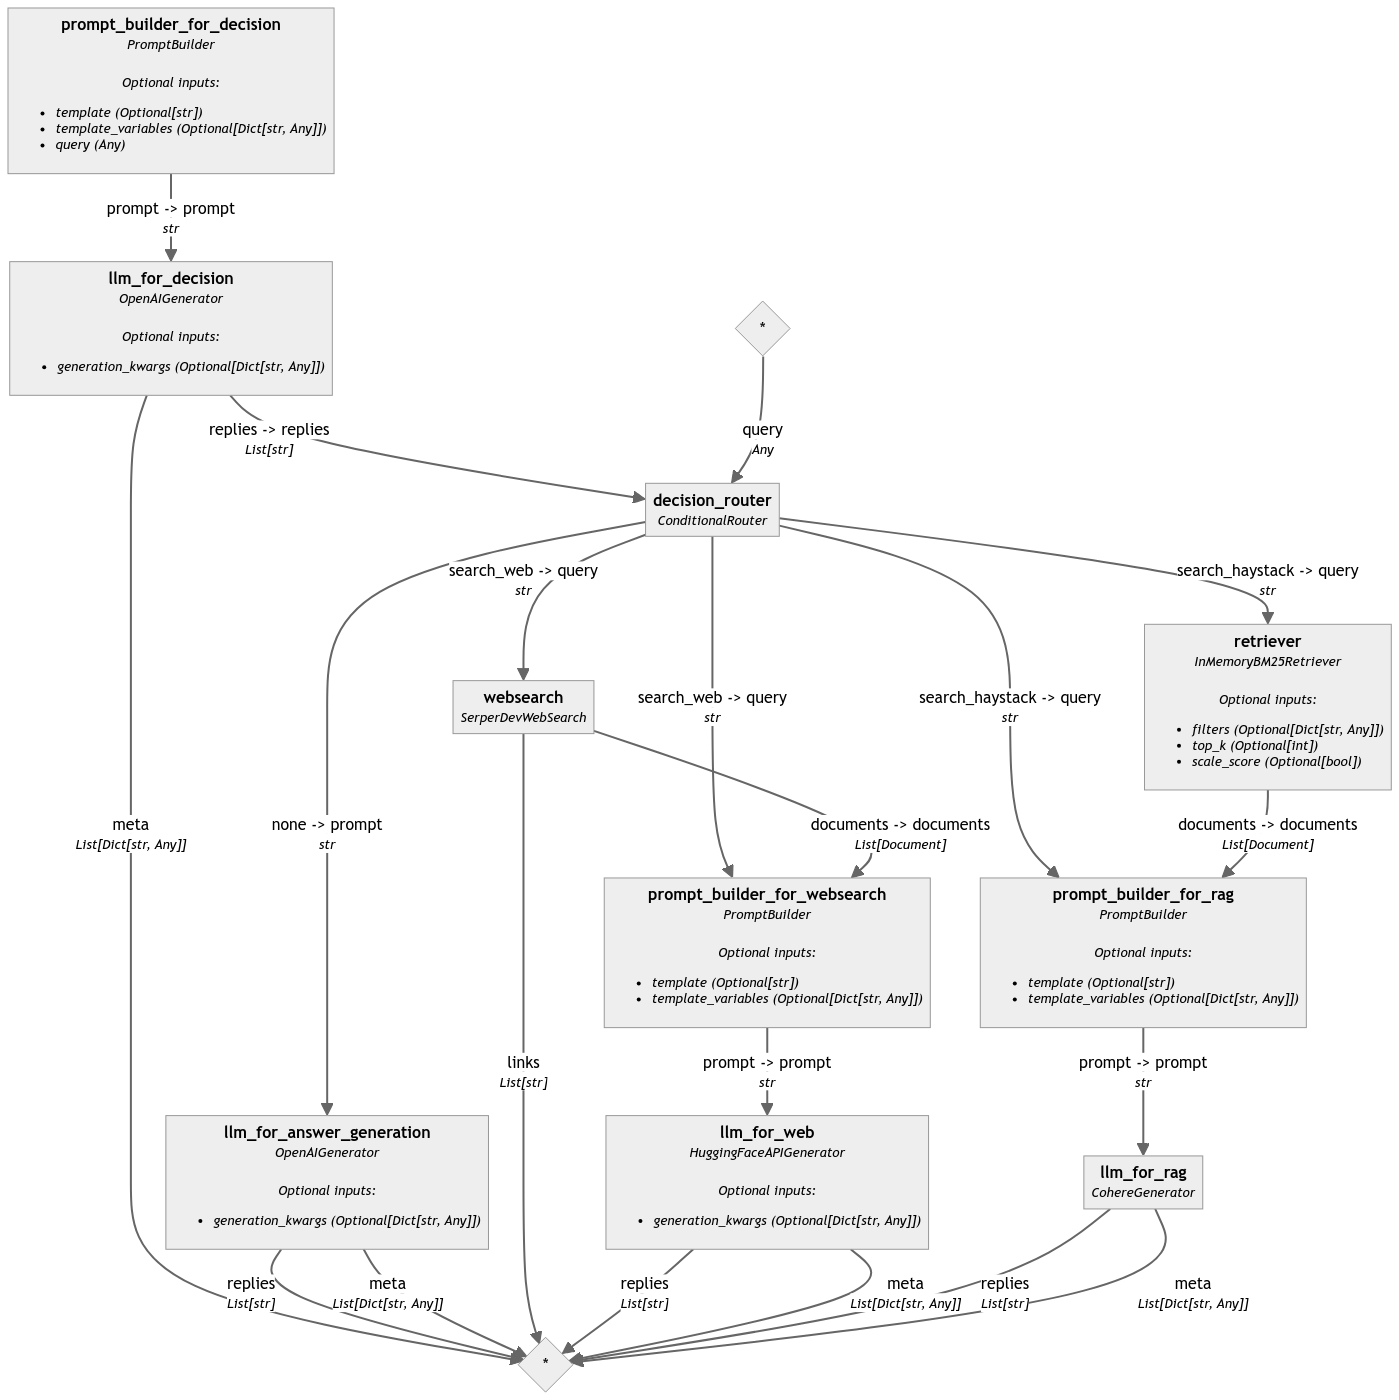

time: 1.82 s (started: 2024-06-10 10:04:51 +00:00)


In [10]:
early_router_pipe.show()